In [1]:
import json
import os

import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import shapely
from shapely.ops import linemerge, split
from tqdm import tqdm

In [2]:
def chop_at_antimeridian(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Cut LineStrings either side of antimeridian, then drop the fragments that
        intersect with antimeridian.

    Warning: Will create new rows (split geometries) with duplicate indices.

    Args:
        gdf: Table with geometry to chop at antimeridian

    Returns:
        Table, potentially with new rows. No rows in the table should have
            geometries that cross the antimeridian.
    """
    assert set(gdf.geometry.type) == {'LineString'}
    
    def split_on_meridian(gdf: gpd.GeoDataFrame, meridian: shapely.geometry.LineString) -> gpd.GeoDataFrame:
        return gdf.assign(geometry=gdf.apply(lambda row: split(row.geometry, meridian), axis=1)).explode(index_parts=False)

    xlim = 179.9
    ylim = 90

    split_e = split_on_meridian(gdf, shapely.geometry.LineString([(xlim, ylim), (xlim, -ylim)]))
    split_e_and_w = split_on_meridian(split_e, shapely.geometry.LineString([(-xlim, ylim), (-xlim, -ylim)]))

    def crosses_antimeridian(row: pd.Series) -> bool:
        """
        Check if there are longitudes in a geometry that are near the antimeridian 
            (i.e. -180) and both sides of it. If so, return true.
        """
        x, _ = row.geometry.coords.xy
        longitudes_near_antimeridian = np.array(x)[np.argwhere(np.abs(np.abs(x) - 180) < xlim).ravel()]
        if len(longitudes_near_antimeridian) == 0:
            return False
        hemispheres = np.unique(np.sign(longitudes_near_antimeridian))
        if (-1 in hemispheres) and (1 in hemispheres):
            return True
        else:
            return False

    return split_e_and_w[~split_e_and_w.apply(crosses_antimeridian, axis=1)]

In [3]:
def plot_global_trade_flows(edges: gpd.GeoDataFrame, filename: str, vmin: float, vmax: float) -> None:
    f, ax = plt.subplots(figsize=(16, 8))
    
    edges_with_volume = edges[(edges.volume_tons != 0) & edges["mode"].isin({"maritime", "imaginary"})]
    edges_with_volume_and_geometry = edges_with_volume[~edges_with_volume.geometry.isna()]
    to_plot = chop_at_antimeridian(edges_with_volume_and_geometry)
    not_imaginary_mask = to_plot["mode"] != "imaginary"
    
    norm = LogNorm(10**np.log10(vmin), 10**np.log10(vmax))
    
    to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
        "volume_tons",
        ax=ax,
        norm=norm,
        legend=True,
        legend_kwds={"shrink": 0.6, "label": "Flow volume [t/d]"},
        cmap="magma_r",
    )
    to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax, norm=norm, ls="--", alpha=0.35, cmap="magma_r")

    world.plot(ax=ax, lw=0.5, alpha=0.2)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylim(-65, 85)
    ax.set_xlim(-180, 180)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")

    f.savefig(filename)

In [4]:
def plot_in_country_trade_flows(edges: gpd.GeoDataFrame, filename: str, vmin: float, vmax: float) -> None:
    f, ax = plt.subplots(figsize=(12, 12))
    
    to_plot = edges[
        (edges.volume_tons != 0) 
        & edges["mode"].isin(
            {
                'road_rail',
                'maritime_road',
                'maritime_rail',
                'road',
                'rail',
                #'maritime',
                #'imaginary'
            }
        )
    ]
    not_imaginary_mask = to_plot["mode"] != "imaginary"
    norm = LogNorm(10**np.log10(vmin), 10**np.log10(vmax))
    to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
        "volume_tons", ax=ax, legend=True, norm=norm, alpha=0.7, legend_kwds={"shrink": 0.5, "label": "Flow volume [t/d]"}, cmap="magma_r"
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_yticks(range(5, 22))
    ax.set_xticks(range(98, 106))
    world.plot(ax=ax, lw=0.5, alpha=0.2)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    f.savefig(filename)

In [5]:
def year_to_day(df: pd.DataFrame, cols=("value_kusd", "volume_tons")) -> pd.DataFrame:
    for col in cols:
        df[col] /= 365.24
    return df

In [6]:
plt.style.use("bmh")

root_dir = ".."

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))

nominal_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/")
degraded_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/hazard-thai-floods-2011-JBA/")
nominal_edges = gpd.read_parquet(os.path.join(nominal_dir, "edges.gpq"))
degraded_edges = gpd.read_parquet(os.path.join(degraded_dir, "edges.gpq"))
data = {
    "nominal": {
        "edges": year_to_day(nominal_edges),
        "routes": year_to_day(pd.read_parquet(os.path.join(nominal_dir, "routes_with_costs.pq"))),
    },
    "degraded": {
        "edges": year_to_day(degraded_edges),
        "routes": year_to_day(pd.read_parquet(os.path.join(degraded_dir, "routes_with_costs.pq"))),
    }
}

/tmp/ipykernel_142144/1457740094.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


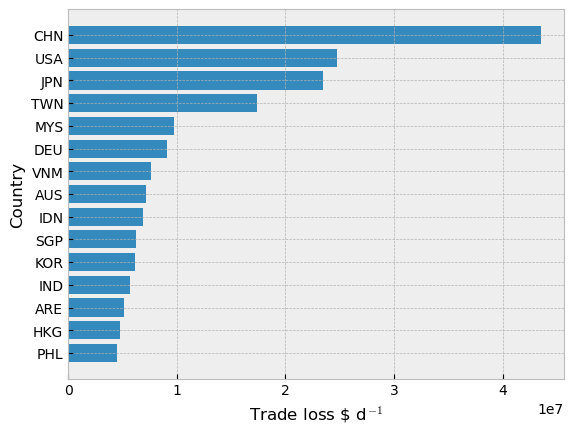

In [7]:
nominal = data["nominal"]["routes"].loc[:, ["destination_node", "value_kusd"]].groupby("destination_node")\
    .sum().rename(columns={"value_kusd": "nominal"})
degraded = data["degraded"]["routes"].loc[:, ["destination_node", "value_kusd"]].groupby("destination_node")\
    .sum().rename(columns={"value_kusd": "degraded"})
partner_value = nominal.join(degraded)
partner_value["abs_change_kusd"] = partner_value.nominal - partner_value.degraded
partner_value["perc_change"] = 100 * partner_value.abs_change_kusd / partner_value.nominal
top_change = partner_value.sort_values("abs_change_kusd", ascending=False).iloc[:15]
f, ax = plt.subplots()
ax.barh(top_change.index[::-1], top_change.abs_change_kusd[::-1] * 1E3)
ax.set_xlabel(r"Trade loss \$ d$^{-1}$")
ax.set_ylabel("Country")
f.savefig("trade_loss_by_country.png")

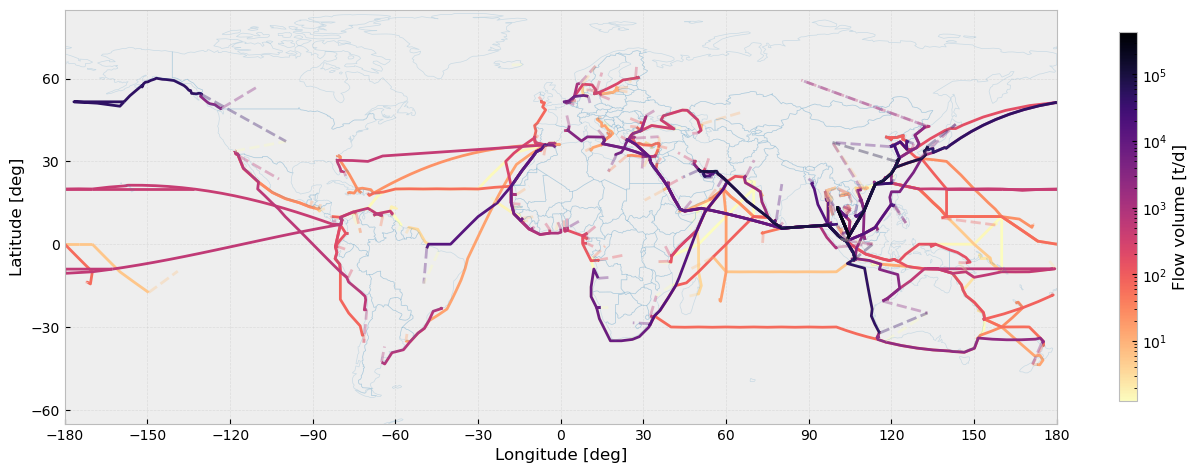

In [8]:
edges = data["nominal"]["edges"]
edges = edges.loc[(edges.volume_tons != 0) & edges["mode"].isin({"maritime", "imaginary"}), :]
vmin = edges.volume_tons.quantile(0.1)
vmax = edges.volume_tons.max()
plot_global_trade_flows(data["nominal"]["edges"], "trade_flow_allocation_global.png", vmin, vmax)

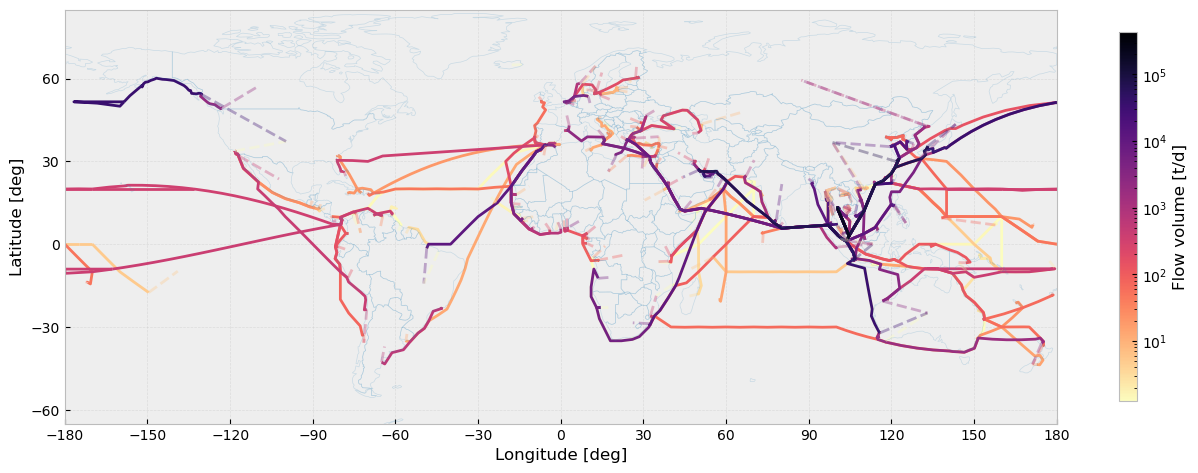

In [9]:
plot_global_trade_flows(data["degraded"]["edges"], "trade_flow_allocation_global_degraded.png", vmin, vmax)

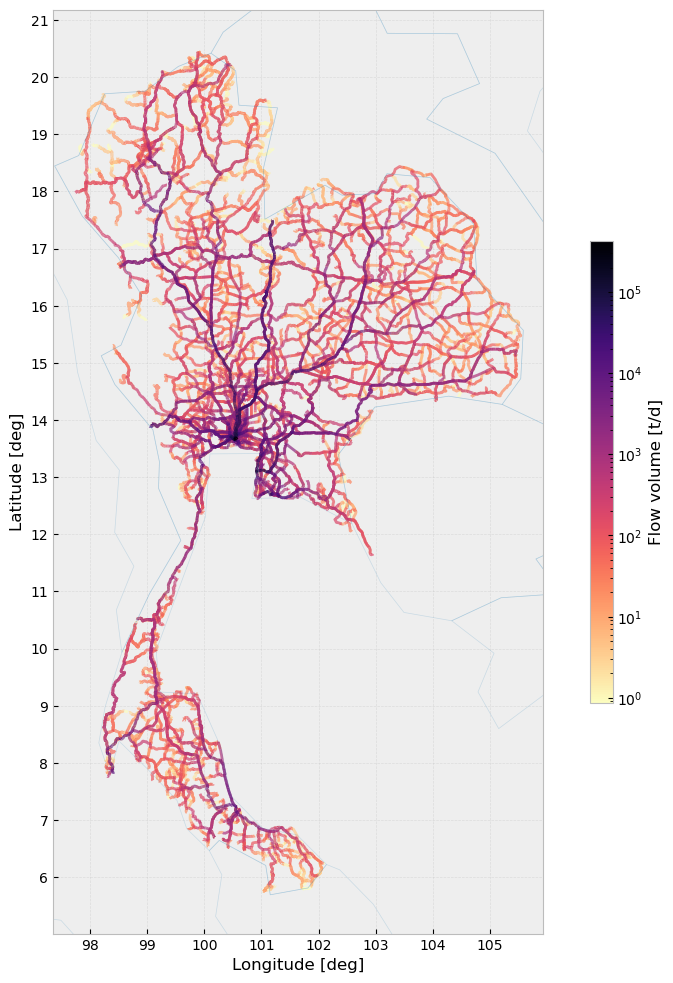

In [10]:
edges = data["nominal"]["edges"]
edges = edges.loc[
    (edges.volume_tons != 0) & edges["mode"].isin({'road_rail','maritime_road','maritime_rail','road','rail'})
]
vmin = edges.volume_tons.quantile(0.1)
vmax = edges.volume_tons.max()
plot_in_country_trade_flows(data["nominal"]["edges"], "trade_flow_allocation_local.png", vmin, vmax)

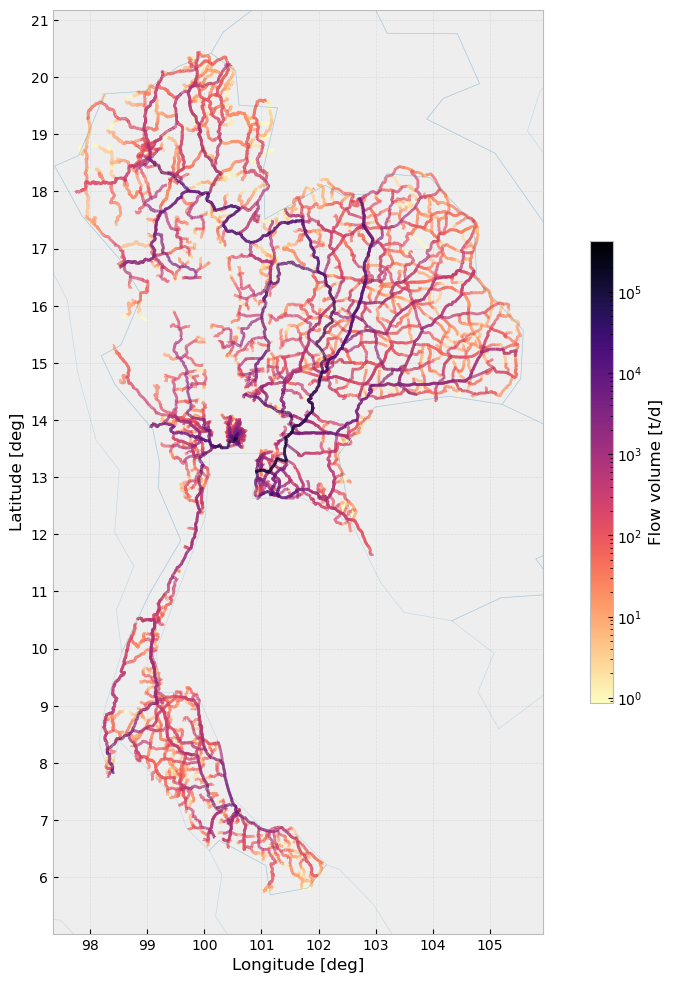

In [11]:
plot_in_country_trade_flows(data["degraded"]["edges"], "trade_flow_allocation_local_degraded.png", vmin, vmax)

In [12]:
# fraction of trade value successfully routed given degraded network
def print_summary(nominal: pd.DataFrame, degraded: pd.DataFrame, var: str) -> None:
    print(var)
    print(f"nominal: {nominal[var].sum():.2E}")
    print(f"degraded {degraded[var].sum():.2E}")
    print(f"difference {nominal[var].sum() - degraded[var].sum():.2E}")
    fraction_lost = 1 - (degraded[var].sum() / nominal[var].sum())
    print(f"fraction_lost: {fraction_lost:.3f}")

print_summary(data["nominal"]["routes"], data["degraded"]["routes"], "value_kusd")
print()
print_summary(data["nominal"]["routes"], data["degraded"]["routes"], "volume_tons")

value_kusd
nominal: 1.45E+06
degraded 1.23E+06
difference 2.20E+05
fraction_lost: 0.152

volume_tons
nominal: 8.35E+05
degraded 7.12E+05
difference 1.23E+05
fraction_lost: 0.147


In [13]:
data["degraded"]["routes"]
data["degraded"]["routes"]["flow_cost_USD_d"] = data["degraded"]["routes"].cost_USD_t * data["degraded"]["routes"].volume_tons

nominal: p90 = 49.41
degraded: p90 = 64.55


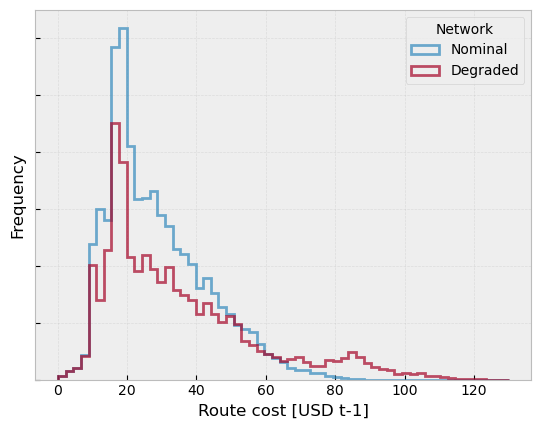

In [14]:
f, ax = plt.subplots()
alpha = 0.7
for colour, scenario in (('#348ABD', "nominal"), ('#A60628', "degraded")):
    
    data[scenario]["routes"].cost_USD_t.hist(
        ax=ax,
        bins=np.linspace(0.1, 130, 60),
        alpha=alpha,
        label=f"{scenario.capitalize()}",# cost USD t-1",
        histtype="step",
        lw=2,
        color=colour
    )
    level = 0.9
    quantile = data[scenario]["routes"].cost_USD_t.quantile(level)
    print(f"{scenario}: p{level * 100:.0f} = {quantile:.2f}")
ax.legend(title="Network")
ax.grid(alpha=0.3)
ax.set_yticklabels([])
ax.set_xlabel("Route cost [USD t-1]")
ax.set_ylabel("Frequency")
f.savefig("route_cost_comparison.png")